# Más sobre evaluación de modelos y selección de features (primera parte)

En este primer notebook vamos a buscar entender como el umbral para asignar las clases nos permite ajustar el error tipo 1 y tipo 2, resolver el problema de clases desbalanceadas, y conseguir una métrica de performance que nos diga qué tan bueno es el clasificador independientemente de valores específicos para los errores tipo 1 y  2. 

Seguimos trabajando con los datos de INTA, así que repetimos el proceso para cargarlos.

In [ ]:
# Como siempre, tratamos de traer todos los paquetes al ppio
from google.colab import drive # Para montar nuestro drive en la consola
import matplotlib.pylab as plt # Para gráficos
import numpy as np # Para manejo de arrays, operaciones matemáticas, etc.
from sklearn.linear_model import LogisticRegression # El método de regresión logística que vamos a usar
import pandas as pd # Para manejo de base de datos

# Traemos los datos
drive.mount('/content/drive') # Montamos nuestra unidad de Google Drive

filename = '/content/drive/My Drive/LaboDatos2021/datosDiariosSanFernandoINTA.xls'

d = pd.read_excel(filename) # Levantamos los datos, en este caso, con el método pd.read_excel


Mounted at /content/drive


Luego, filtramos el dataframe descartando columnas con datos faltantes, seleccionamos un subconjunto de columnas, y las renombramos.

In [ ]:
d_filtrado = d[['Temperatura_Abrigo_150cm_Maxima',
                'Temperatura_Abrigo_150cm_Minima',
                'Precipitacion_Pluviometrica',
                'Velocidad_Viento_Maxima',
                'Rocio_Medio',
                'Humedad_Media', 'Tesion_Vapor_Media']].dropna().copy() # Nos quedamos con ciertos campos del data set, para facilitar el trabajo. Y para limitarlo.
                                                  # Notar que primero aplicamos el método .dropna() para eliminar filas que tengan alguna columna con NaN 
                                                  # Ademas, el metodo copy() nos asegura que estemos creando un nuevo dataframe 
d_filtrado.rename({'Temperatura_Abrigo_150cm_Maxima' : 'temperaturaMaxima',
                   'Temperatura_Abrigo_150cm_Minima' : 'temperaturaMinima',
                   'Precipitacion_Pluviometrica' : 'precipitacion',
                   'Humedad_Media' : 'humedad',
                   'Rocio_Medio' : 'rocio',
                   'Velocidad_Viento_Maxima' : 'viento', 'Tesion_Vapor_Media': 'vapor'},
                  axis = 1,
                  inplace = True) # Esto toma como input un diccionario en el cual las llaves son los nombres actuales de columnas, y los valores los nombres nuevos (a los que queremos renombrar)
                                  # axis = 1 es porque queremos renombrar columnas, y inplace=True es porque queremos "pisar" el dataframe al renombrarlo

Finalmente, construimos una variable con las etiquetas de los días lluviosos.




In [ ]:
d_filtrado['llueveNollueve'] = 0 # empezamos con una columna llena de 0. 
indice =  d_filtrado['precipitacion'] > 0  # esto me da los valores del indice para los cuales hay precipitacion mayor a 0
d_filtrado.loc[indice, 'llueveNollueve'] = 1 # entonces para esos valores del indice pongo 1, porque en el dia correspondiente, llovio

d_filtrado['llueveNollueve'].value_counts()

0    717
1    337
Name: llueveNollueve, dtype: int64

# Efecto del umbral de clasificación en el error

Vamos a construir un clasificador **sin balancear** con todas las features, pero en vez de obtener las predicciones binarias, vamos a obtener las probabilidades.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Definamos la matriz X
campos = ['temperaturaMinima', 'temperaturaMaxima', 'humedad', 'rocio', 'vapor'] # Lista que contiene las features de interés.
X = d_filtrado[campos].values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
y = d_filtrado['llueveNollueve'] # Nuestra etiqueta sigue siende la misma de antes

scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X) # encuentro los parametros para el escaleo
X = scaler.transform(X) # aplico la transformacion

regLog = LogisticRegression(penalty = 'none', max_iter=10000) # Inicializamos nuevamente el modelo
regLog.fit(X, y) # Ajustamos el modelo con los parámetros
probas = regLog.predict_proba(X)  # este es el metodo para obtener las predicciones de probabilidades en base a la matriz features
print(probas)



[[0.59264569 0.40735431]
 [0.66611066 0.33388934]
 [0.7071929  0.2928071 ]
 ...
 [0.52618364 0.47381636]
 [0.61590414 0.38409586]
 [0.64470929 0.35529071]]


La primera columna es $P(y=0|x,\beta)$. 

La segunda es $P(y=1|x,\beta)$. 

Entonces, el clasificador por defecto predice etiqueta $1$ si $P(y=1|x,\beta) > 0.5$, o sea, cuando la segunda columna es mayor que 0.5 y la etiqueta $0$ en caso contrario.

Pero podemos introducir un umbral arbitrario $T$ para determinar la etiqueta $1$ si $P(y=1|x,\beta) > T$. 

Veamos como queda la matriz de confusión para distintas elecciones de T.

Ademas, vamos a calcular dos medidas de performance útiles para más adelante:

*   Tasa de verdaderos positivos (sensibilidad)$ = \frac{TP}{TP+FN}$
*   Tasa de falsos positivos$ = \frac{FP}{FP+TN}$

donde TP = verdaderos positivos, FN = falsos negativos, FP = falsos positivos y TN = verdaderos negativos.


In [ ]:
from sklearn.metrics import confusion_matrix

def TPR_FPR(cm): # computa la tasa de verdaderos y falsos positivos a partir de la matriz de confusion
  TPR = cm[1,1]/(cm[1,1]+cm[0,1])
  FPR = cm[1,0]/(cm[1,0]+cm[0,0])
  return [TPR,FPR] # devuelve una lista donde el primer elemento es la tasa de verdaderos positivos y el segundo la tasa de falsos negativos

T = 0.5 # definimos el umbral
ypred = np.zeros(probas.shape[0]) # armamos un vector que tiene todos ceros y tiene la longitud del vector de etiquetas
ypred[probas[:,1]>T] = 1 # donde la probabilidad es mayor que T, ponemos 1
cm = confusion_matrix(ypred, y) # metemos en la matriz de confusion
metricas = TPR_FPR(cm)

print('Matriz de confusion del modelo es:')
print(cm)
print('Tasa de verdaderos positivos: {}'.format(round(metricas[0],4)))  
print('Tasa de falsos positivos: {}'.format(round(metricas[1],4)))  



Matriz de confusion del modelo es:
[[646 209]
 [ 71 128]]
Tasa de verdaderos positivos: 0.3798
Tasa de falsos positivos: 0.099


Esto es lo que ya sabíamos del notebook pasado: como el dataset está desbalanceado, tendemos a detectar pocos verdaderos positivos (días de lluvia) a cambio de que haya pocos falsos positivos. 

**En otras palabras: el clasificador está sesgado para predecir que no llueve.**

Pero si bajamos el umbral T, deberíamos encontrar que se hace más fácil predecir que llueve, y entonces que la matriz se balancea:

In [ ]:
T = 0.3 # probamos con un umbral menor a 0.5
ypred = np.zeros(probas.shape[0]) # armamos un vector que tiene todos ceros y tiene la longitud del vector de etiquetas
ypred[probas[:,1]>T] = 1 # donde la probabilidad es mayor que T, ponemos 1
cm = confusion_matrix(ypred, y) # metemos en la matriz de confusion
metricas = TPR_FPR(cm)

print('Matriz de confusion del modelo es:')
print(cm)
print('Tasa de verdaderos positivos: {}'.format(round(metricas[0],4)))  
print('Tasa de falsos positivos: {}'.format(round(metricas[1],4))) 

Matriz de confusion del modelo es:
[[451  99]
 [266 238]]
Tasa de verdaderos positivos: 0.7062
Tasa de falsos positivos: 0.371


Ahora ya la tasa de detección de verdaderos positivos es >0.5.
Naturalmente, también creció la tasa de falsos positivos.

Si hubiese elegido un umbral T > 0.5, el efecto hubiese sido el opuesto.

In [ ]:
T = 0.7 # probamos con un umbral mayor a 0.5
ypred = np.zeros(probas.shape[0]) # armamos un vector que tiene todos ceros y tiene la longitud del vector de etiquetas
ypred[probas[:,1]>T] = 1 # donde la probabilidad es mayor que T, ponemos 1
cm = confusion_matrix(ypred, y) # metemos en la matriz de confusion
metricas = TPR_FPR(cm)

print('Matriz de confusion del modelo es:')
print(cm)
print('Tasa de verdaderos positivos: {}'.format(round(metricas[0],4)))  
print('Tasa de falsos positivos: {}'.format(round(metricas[1],4))) 

Matriz de confusion del modelo es:
[[712 310]
 [  5  27]]
Tasa de verdaderos positivos: 0.0801
Tasa de falsos positivos: 0.007


En resúmen: para cada valor de T, el modelo tiene una tasa de verdaderos positivos y una de falsos positivos. 

En general, lo ideal es que la tasa de verdaderos positivos sea alta mientras que la de falsos positivos sea baja. **Pero... ¿para qué umbral?**




# Área bajo la curva ROC

Vamos a construir un indicador que surja de comparar la tasa de verdaderos positivos vs. la tasa de falsos positivos **para todo valor posible de T.**

Para eso, consideremos varios valores de T y visualicemos el valor de ambas tasas para cada uno de ellos:

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95]


Text(0, 0.5, 'Tasa de verdaderos positivos')

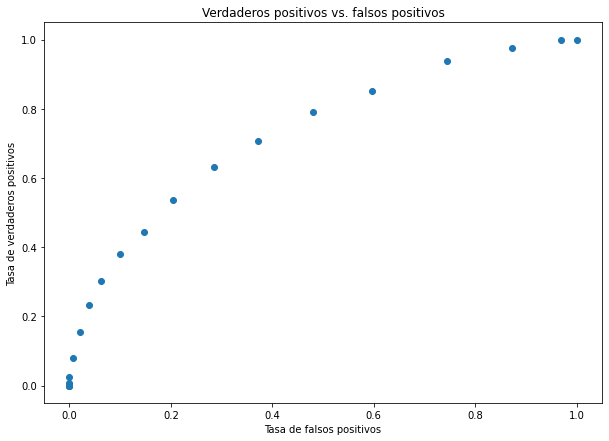

In [ ]:
Ts = np.arange(0,1,0.05) # T va desde 0 a 1 en pasos de 0.05
print(Ts)
TPRs = []  # lista donde van a ir a parar mis tasas de verdaderos positivos
FPRs = []  # lista donde van a ir a parar mis tasas de falsos positivos
for T in Ts: # recorre los umbrales en la lista Ts
  ypred = np.zeros(probas.shape[0]) # armamos un vector que tiene todos ceros y tiene la longitud del vector de etiquetas
  ypred[probas[:,1]>T] = 1 # donde la probabilidad es mayor que T, ponemos 1
  cm = confusion_matrix(ypred, y) # metemos en la matriz de confusion
  metricas = TPR_FPR(cm) # calculamos las metricas con la función definida más arriba
  TPRs.append(metricas[0]) # guardamos los resultados en las listas respectivas
  FPRs.append(metricas[1])

fig, ax = plt.subplots(figsize = (10,7))
ax.set_title('Verdaderos positivos vs. falsos positivos')
ax.scatter(FPRs,TPRs)
ax.set_xlabel('Tasa de falsos positivos') # Etiqueta del eje x
ax.set_ylabel('Tasa de verdaderos positivos') # Etiqueta del eje y



Repitamos nuevamente tomando una separación mucho más pequeña entre los T:

Text(0, 0.5, 'Tasa de verdaderos positivos')

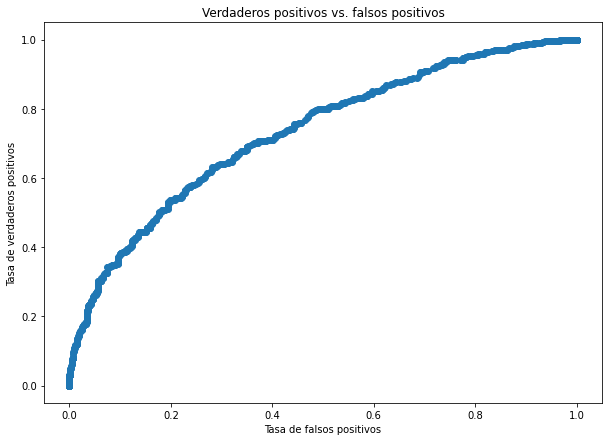

In [ ]:
Ts = np.arange(0,1,0.001) # T va desde 0 a 1 en pasos de 0.001
TPRs = []  # lista donde van a ir a parar mis tasas de verdaderos positivos
FPRs = []  # lista donde van a ir a parar mis tasas de falsos positivos
for T in Ts: # recorre los umbrales en la lista Ts
  ypred = np.zeros(probas.shape[0]) # armamos un vector que tiene todos ceros y tiene la longitud del vector de etiquetas
  ypred[probas[:,1]>T] = 1 # donde la probabilidad es mayor que T, ponemos 1
  cm = confusion_matrix(ypred, y) # metemos en la matriz de confusion
  metricas = TPR_FPR(cm) # calculamos las metricas con la función definida más arriba
  TPRs.append(metricas[0]) # guardamos los resultados en las listas respectivas
  FPRs.append(metricas[1])

fig, ax = plt.subplots(figsize = (10,7))
ax.set_title('Verdaderos positivos vs. falsos positivos')
ax.scatter(FPRs,TPRs)
ax.set_xlabel('Tasa de falsos positivos') # Etiqueta del eje x
ax.set_ylabel('Tasa de verdaderos positivos') # Etiqueta del eje y

Vemos que se va armando una curva. Esta curva se llama "curva ROC" (por  *receiver operating characteristic curve*) y representa la capacidad de detectar casos positivos vs. el error cometido (falsa detección de casos positivos) a medida que el umbral se va cambiando entre todos sus valores posibles.

Consideremos las siguientes observaciones:

1.   Si el clasificador es a "nivel chance", entonces se equivoca tanto como acierta. **Por lo tanto, la tasa de verdaderos positivos es igual a la de falsos positivos, y la curva ROC es la identidad.**

2.   La curva es siempre creciente (porque al aumentar el umbral, las etiquetas predichas como positivas son un subconjunto de las predichas como positivas con un umbral menor, y son el subconjunto con mayor probabilidad de efectivamente tener esa etiqueta).

3.   Un buen clasificador obtiene un valor **alto** de tasa de verdaderos positivos para un valor **bajo** de tasa de falsos negativos, o sea, tiene que tener un punto cerca de las coordenadas (0,1). Como la curva es creciente, esto significa que un buen clasificador tiene la pinta:

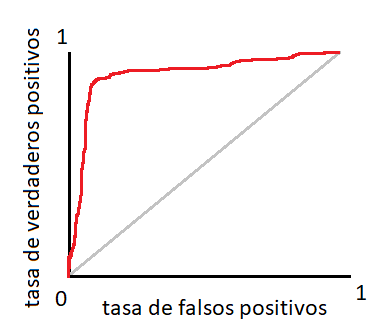

Se sigue entonces que el clasificador perfecto alcanza (0,1) y el área bajo su curva ROC es 1. Más cerca de 1 esté el área bajo la curva ROC, mejor será el clasificador. Además, como el "nivel chance" está dado por la identidad, entonces el área bajo la curva ROC asociada es 0.5.

Introducimos entonces la métrica AUC que representa el área bajo la curva (*area under the curve*) ROC.

Veamos como plotear curvas ROC y calcular el AUC con scikit-learn.  


AUC: 0.7323


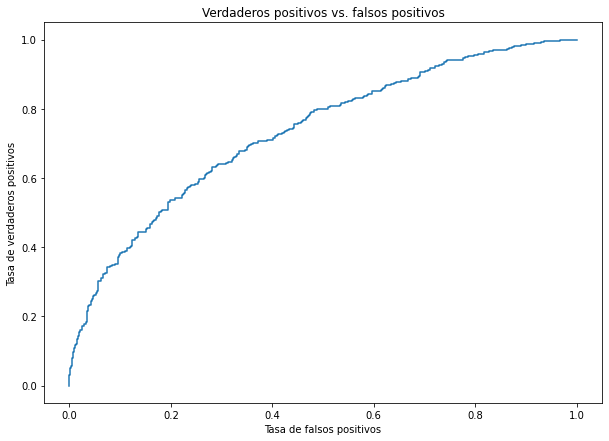

In [ ]:
from sklearn.metrics import roc_curve # función curva ROC de scikit-learn
from sklearn.metrics import roc_auc_score # función AUC de scikit-learn

fpr, tpr, thresholds = roc_curve(y, probas[:,1]) # Función ROC: recibe las etiquetas verdaderas y las probas de que sean 1
                                                # Devuelve las tastas de falsos positivos y verdaderos positivos, además de los 
                                                # umbrales a los que están calculados
fig, ax = plt.subplots(figsize = (10,7))
ax.set_title('Verdaderos positivos vs. falsos positivos')
ax.plot(fpr,tpr) # Gráfico de TPR vs FPR
ax.set_xlabel('Tasa de falsos positivos') # Etiqueta del eje x
ax.set_ylabel('Tasa de verdaderos positivos') # Etiqueta del eje y

auc = roc_auc_score(y, probas[:,1]) # Cálculo del área debajo de la curva, recibe también las etiquetas verdaderas 
                                    # y la proba de que valgan 1.

print('AUC: {}'.format(round(auc,4))) # mostramos el AUC con 4 cifras significativas 




El AUC es una de las métricas más usadas para evaluar la performance de modelos, porque funciona independientemente de una única forma particular de balancear los datos. Si para el problema en particular fuese necesario, se presenta también una matriz de confusión armada con algún umbral elegido para minimizar el error tipo 1 o tipo 2, dependiendo de la naturaleza del problema.

# Para llevarse de este notebook

Lo más importante es el código para obtener el AUC y la idea detrás:

```
# auc = roc_auc_score(y, probas[:,1])
```

donde $y$ son los labels y probas es la matriz que tiene en su primera columna la probabilidad de que el label sea 0, y en la segunda de que sea 1 (ambas columnas suman siempre 1).

También es útil el siguiente código para plotear curvas ROC:


```

fpr, tpr, thresholds = roc_curve(y, probas[:,1])
fig, ax = plt.subplots()
ax.set_title('Verdaderos positivos vs. falsos positivos')
ax.plot(fpr,tpr)
ax.set_xlabel('Tasa de falsos positivos') 
ax.set_ylabel('Tasa de verdaderos positivos')

```




# Preguntas extra

*   Volver a clasificadores de notebooks pasados y calcular el AUC
*   ¿Cómo interpretarías un AUC < 0.5?
*   Responder qué hay de erroneo en el siguiente razonamiento:

"Si mi AUC<0.5, entonces mi clasificador esta aprendiendo las etiquetas al revés. Lo único que necesito es invertir la etiqueta que predice mi clasificador, de forma tal que 0 es 1 y 1 es 0."

